주차 수요 예측 AI 경진대회 https://dacon.io/competitions/official/235745/overview/description

목표 : 🏠 유형별 임대주택 설계 시 단지 내 적정 🅿️ 주차 수요를 예측 (차량등록수)

<br>


In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

<br>

# 데이터 분석 및 전처리

## Dataset Load

In [2]:
train = pd.read_csv('data/train.csv', encoding='utf-8')
test = pd.read_csv('data/test.csv', encoding='utf-8')

## 데이터 분석

### 기본 시각화

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rc

import seaborn as sns

rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

import missingno as msno

In [4]:
# # Mac 유저
# rc('font', family='AppleGothic')
# plt.rcParams['axes.unicode_minus'] = False

# Windows 유저
plt.rcParams['font.family'] = 'Malgun Gothic'

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2952 entries, 0 to 2951
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   단지코드                          2952 non-null   object 
 1   총세대수                          2952 non-null   int64  
 2   임대건물구분                        2952 non-null   object 
 3   지역                            2952 non-null   object 
 4   공급유형                          2952 non-null   object 
 5   전용면적                          2952 non-null   float64
 6   전용면적별세대수                      2952 non-null   int64  
 7   공가수                           2952 non-null   float64
 8   자격유형                          2952 non-null   object 
 9   임대보증금                         2383 non-null   object 
 10  임대료                           2383 non-null   object 
 11  도보 10분거리 내 지하철역 수(환승노선 수 반영)  2741 non-null   float64
 12  도보 10분거리 내 버스정류장 수            2948 non-null   float64
 13  단지내

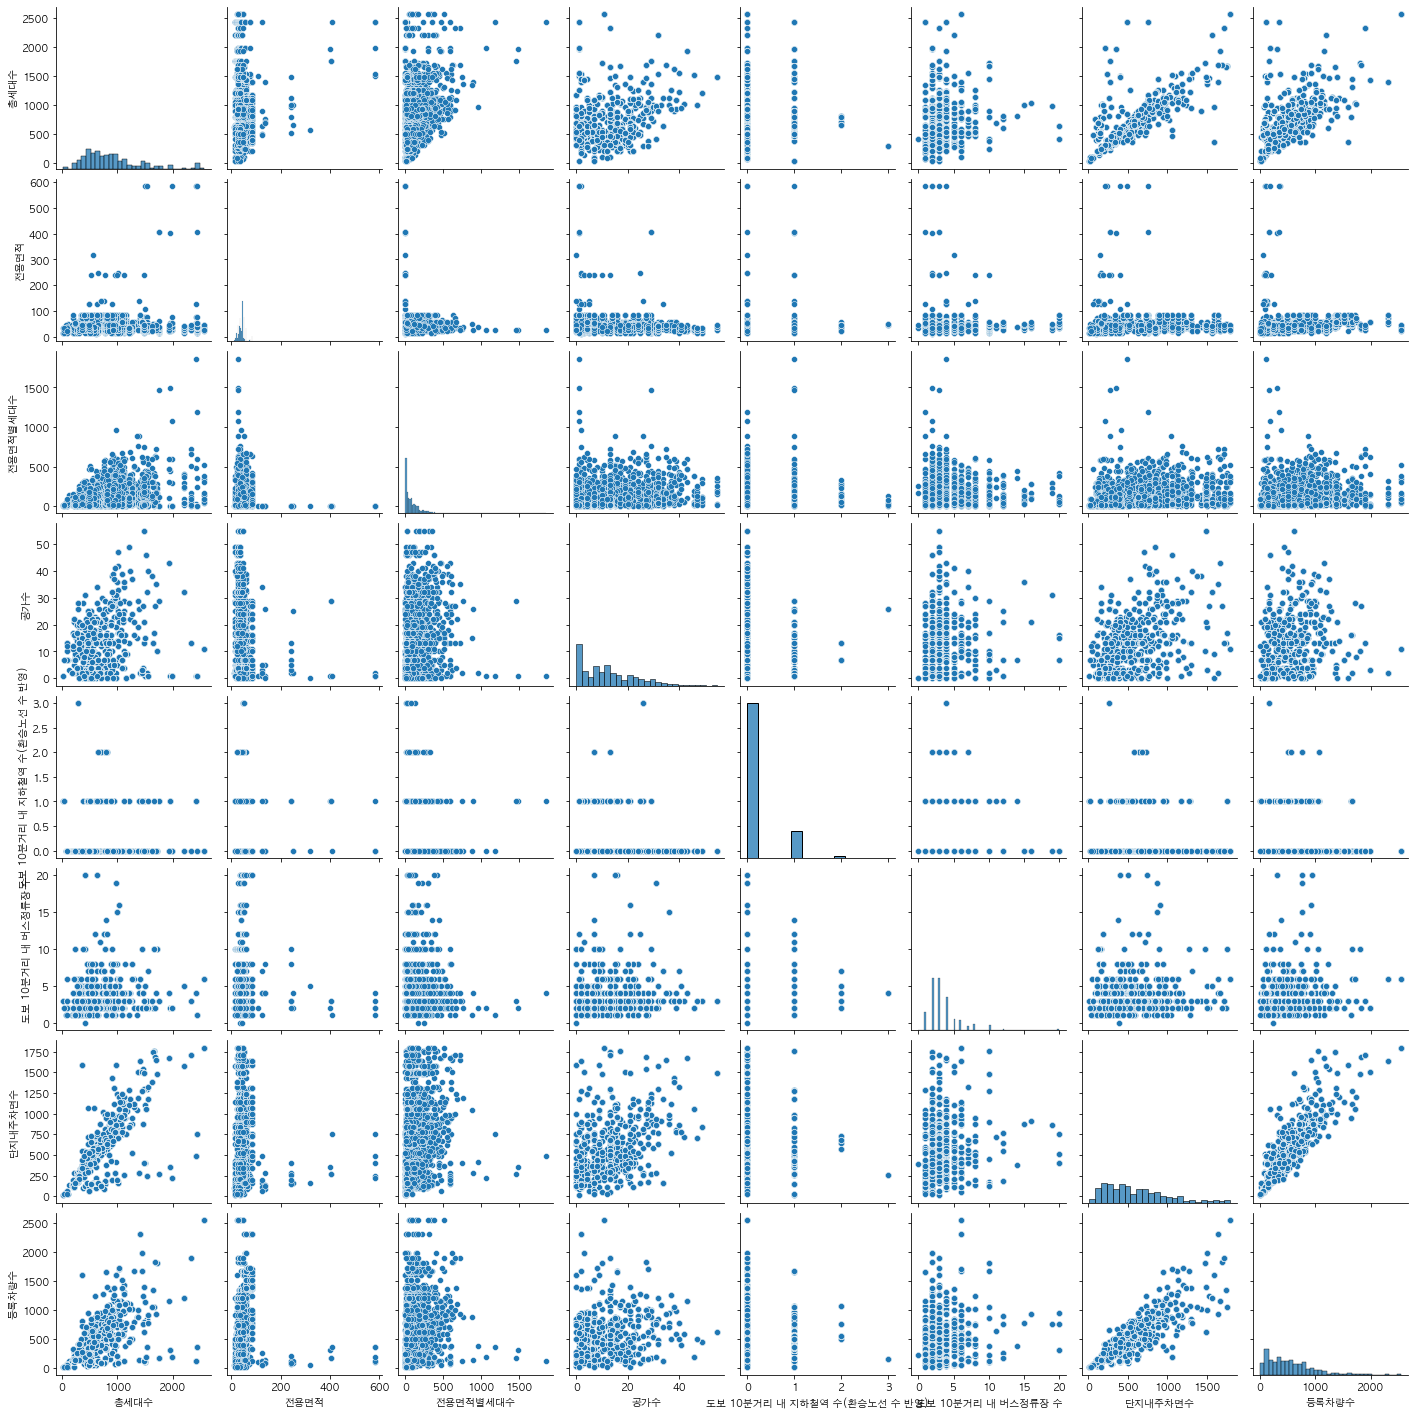

In [5]:
sns.pairplot(train)

### 오류 확인

1. 전용면적별 세대수 합계와 총세대수가 일치하지 않는 경우  

 - (오류 내용) 제공한 데이터(트레인 및 테스트) 중 총 58개 단지에서 전용면적별 세대수 합계가 총세대수보다 적은 경우가 발생하였습니다. 

 - (분포 현황) 차이는 최소 1세대부터 최대 452세대까지이며, 그 가운데 48개 단지(83%) 는 차이가 1~14세대, 나머지 10개 단지(17%) 는 차이가 94~452세대 사이에 분포합니다. 

 - (발생 원인) 차이는 분양상가 또는 분양아파트가 임대단지 안에 혼합되어 발생한 것으로, 분양 완료된 상가 ․ 아파트는 관리대상에서 제외되어 전용면적별 세대수에서는 포함되지 않았으나 총세대수에는 포함되었습니다. 

 - (관련 데이터) 차이가 14세대 이하인 48개 단지는 분양상가, 차이가 94~452세대에 분포하는 10개 단지는 분양아파트 혼합단지인 것으로 확인되며, 아래 10개 단지의 코드를 확인하셔서 데이터 분석에 참고해주시기 바랍니다.

※ 차이가 14세대 이하인 48개 단지 : 하단 별첨 참조
['C1925', 'C1312', 'C2013', 'C1424', 'C2520', 'C2319', 'C1850', 'C1068', 'C2644', 'C2156', C2453', 'C1910', 'C2139', 'C2508', 'C1695', 'C2556', 'C2362', 'C2568', 'C2245', 'C2549', 'C1584', 'C2298', 'C2225', 'C1218', 'C1970', C1732', 'C2433', 'C1894', 'C1156', 'C2142', 'C2186', 'C2411', 'C1812', 'C1030', 'C1749', 'C1349', 'C2043', 'C1229', 'C2363', 'C1414', C2174', 'C2404', 'C1683', 'C1038', 'C2456', 'C1266', 'C1267', 'C2189']

※ 차이가 94~452세대인 10개 단지(크기순) : ['C1490', 'C2497', 'C2620', 'C1344', 'C1024', 'C2470', 'C1206', 'C1740', 'C2405', 'C1804’]

2. 동일한 단지에 단지코드가 2개로 부여된 경우  

 - (오류 내용) 동일한 단지임에도 불구하고 코드가 2개로 부여되어 별개의 단지로 인식되도록 데이터가 제공되었고, 그로 인해 주차면수는 2개 단지에 합산값으로 기재되었고 총세대수는 2개 단지에 각각 계상된 형태로 나타났습니다.

 - (발생 원인) 1번과 마찬가지로 분양과 임대가 혼합된 유형의 단지임으로 인해 발생한 오류이나 1번에서는 분양세대에 단지코드가 부여되지 않고 전용면적별 세대수에서 빠져있는 반면, 2번에서는 분양세대에도 단지코드가 부여되어 별개의 단지인 것처럼 인식되었습니다. 

 - (참고 사항) 주차면수는 하나의 단지임을 전제로 산정된 것이고 총세대수는 두 개 단지의 합계입니다. 다만 등록차량대수는 ['C2085', 'C1397'] 단지의 경우 동일 수치, ['C2431', 'C1649']] 단지의 경우 두 개 단지 합계입니다. 
 ![image.png](image/다운로드.png)



 - (관련 데이터) 아래와 같이 총 3개 단지 6개 코드에서 같은 유형의 오류가 확인되었습니다.  

※ 동일한 단지에 코드가 2개로 부여된 단지 코드 (3쌍) : ['C2085', 'C1397'], ['C2431', 'C1649'], ['C1036', 'C2675'] 

 - C2675 단지는 테스트셋, 나머지는 트레인셋 입니다.

 

3. 단지코드 등 기입 실수로 데이터 정제 과정에서 매칭 오류 발생  

 - (오류 내용) 단지코드 등 기입 실수로 총세대수가 주차면수에 비해 과하게 많거나 적은 경우가 발생하였고, 점검 결과 일부 데이터의 단지코드, 총세대수, 주차면수 등에서 오류가 검출되었습니다.

 - (발생 원인) 원천데이터 수집 과정에서 단지 코드 등이 잘못 기입되었고 이를 인지하지 못한 채 데이터 정제를 하여 오류가 발생하였습니다.

 - (관련 데이터) 아래와 같이 총 9개 단지에서 같은 문제가 확인되었습니다. 

※ 실수가 발생한 단지 코드 (9개 단지) : ['C2335', 'C1327', 'C1095', 'C2051', 'C1218', 'C1894', 'C2483', 'C1502', 'C1988']

 - C2335, C1327 단지는 테스트셋, 나머지는 트레인셋 입니다.




4. 오류 데이터 처리 방안

 - 제공한 데이터상에 문제점이 발견되었으나 대회 중반에 들어선 시점에서 오류를 수정하여 재배포할 경우 혼란이 가중될 것이 우려되어 데이터 수정/재배포는 없을 예정입니다.

 - 1번 오류의 경우 해당 사실을 감안하여 분석을 진행해 주시기 바라며, 2, 3번 오류의 경우에는 문제가 된 단지들을 트레인셋에서 제외하기를 권장드리고, 테스트셋에서는 평가 시 제외하고자 합니다.

 - 테스트셋에서 평가 제외되는 데이터는 'C2675'(2번 사항에 해당), 'C2335', 'C1327'(3번 사항에 해당) 3개 단지입니다.

 - 제출 양식은 변경되지 않으니 기존 제출 양식에 따라 제출 부탁드립니다.('C2675', 'C2335', 'C1327' 단지 예측 결과는 평가되지 않습니다.)

 - 이번에 검출된 오류 외 혹시 모를 추가적인 오류발생을 대비해 데이터 검증을 계속 진행중이며 문제 발견시 공지 및 안내해드리겠습니다.

### 결측치 확인

<AxesSubplot:>

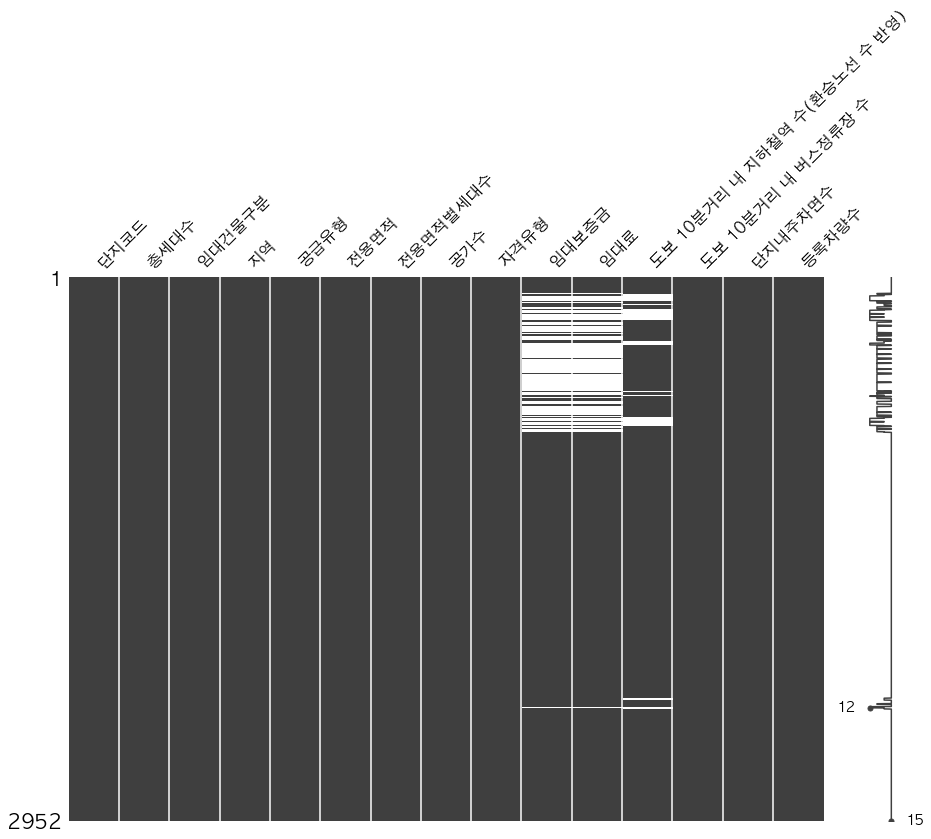

In [6]:
msno.matrix(train, figsize=(15,10))

<AxesSubplot:>

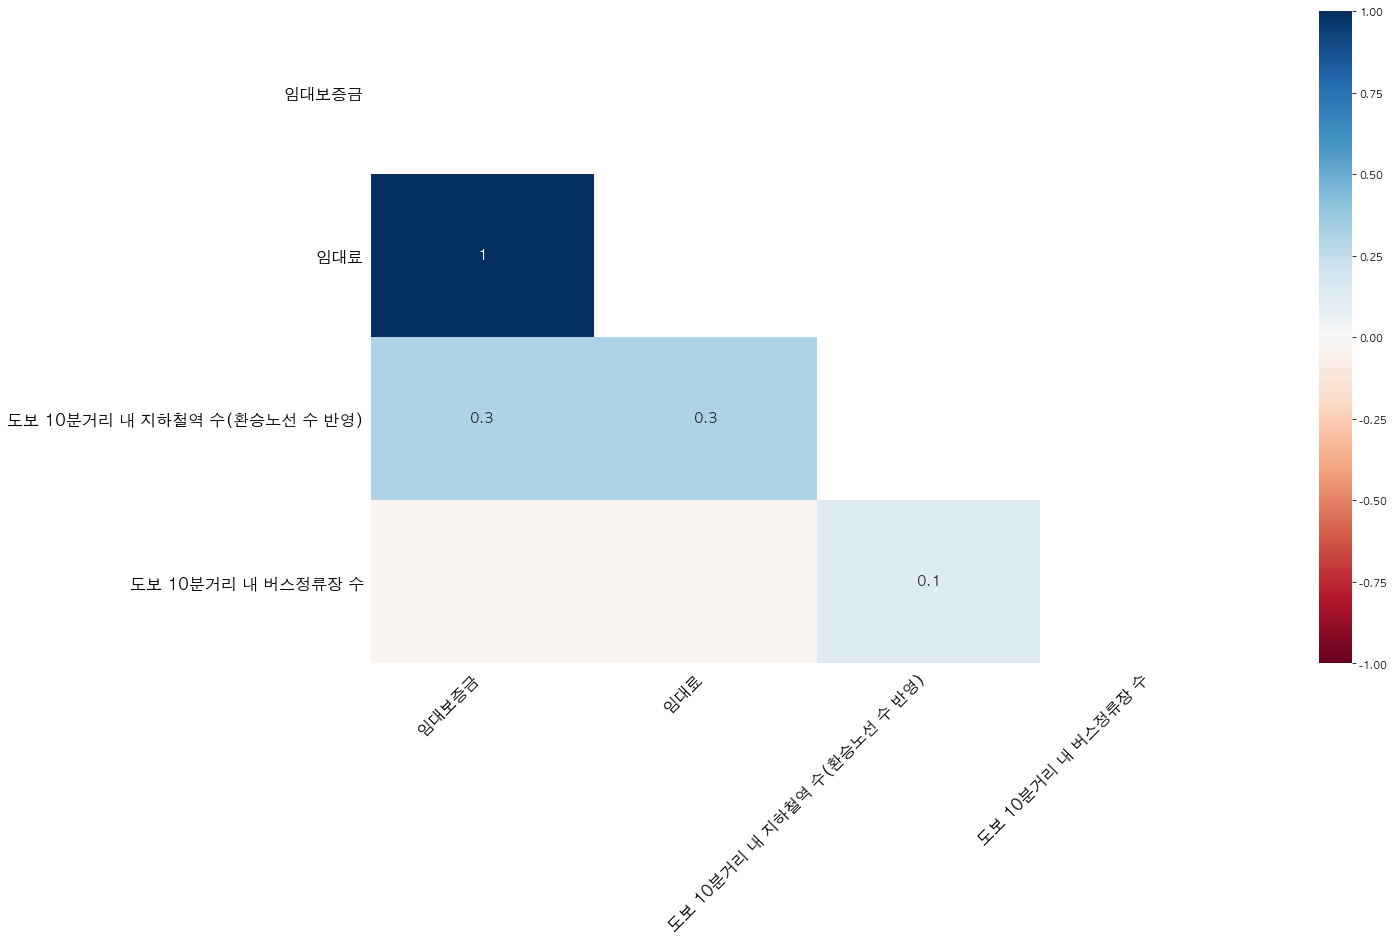

In [7]:
msno.heatmap(train)

In [6]:
train.isnull().sum()

단지코드                              0
총세대수                              0
임대건물구분                            0
지역                                0
공급유형                              0
전용면적                              0
전용면적별세대수                          0
공가수                               0
자격유형                              0
임대보증금                           569
임대료                             569
도보 10분거리 내 지하철역 수(환승노선 수 반영)    211
도보 10분거리 내 버스정류장 수                4
단지내주차면수                           0
등록차량수                             0
dtype: int64

<br>

## 데이터 전처리

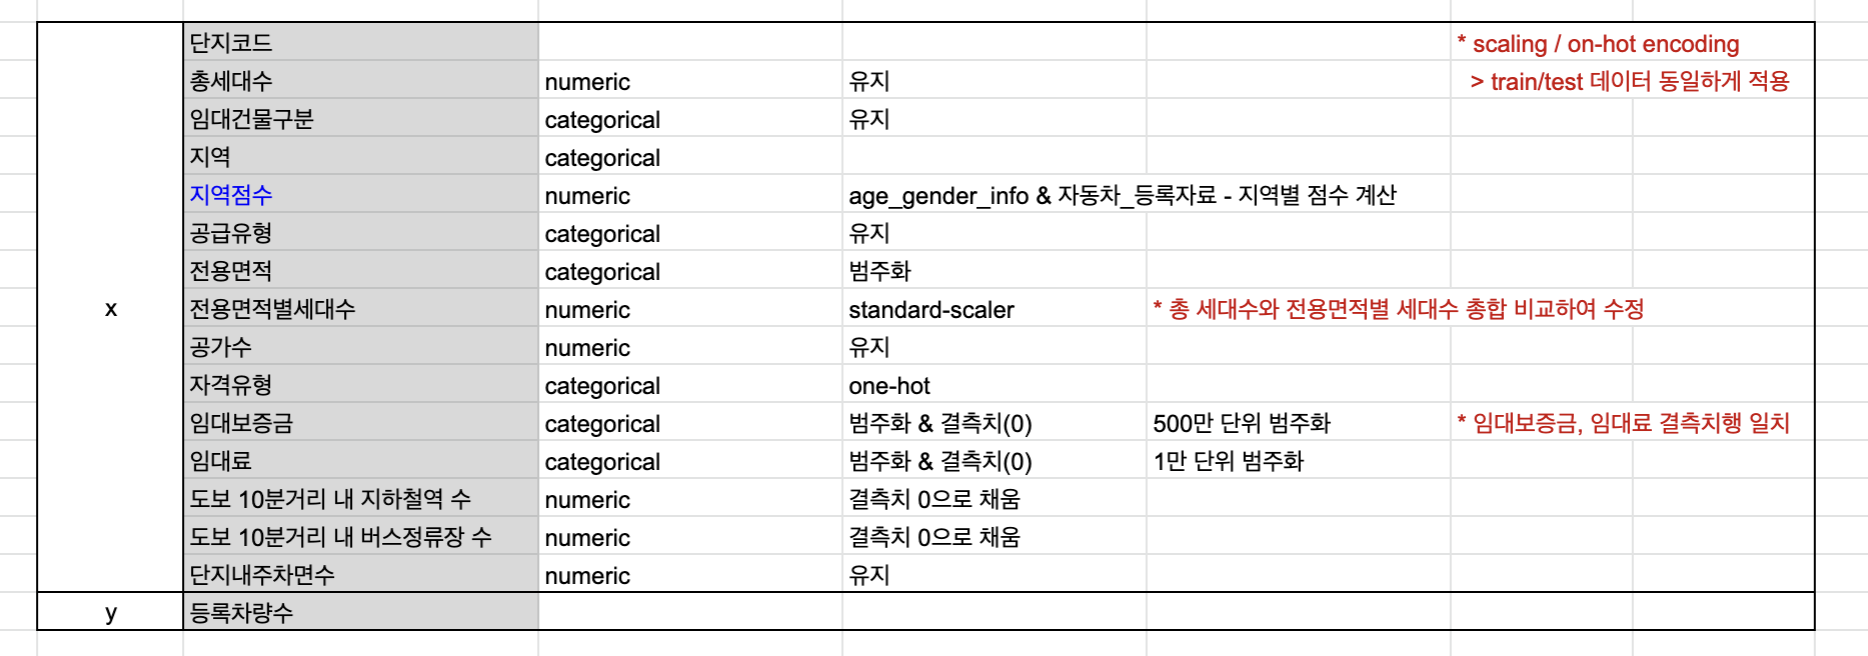

### 오류 해결
#### 2번과 3번 오류가 있는 행
해당 행 삭제

In [7]:
# ['C2085', 'C1397'], ['C2431', 'C1649'], ['C1036', 'C2675']

train = train[train['단지코드']!='C2085']
train = train[train['단지코드']!='C1397']
train = train[train['단지코드']!='C2431']
train = train[train['단지코드']!='C1649']
train = train[train['단지코드']!='C1036']
train = train[train['단지코드']!='C2675']
train = train.reset_index()

del train['index']
train.head()

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수
0,C2483,900,아파트,경상북도,국민임대,39.72,134,38.0,A,15667000,103680,0.0,3.0,1425.0,1015.0
1,C2483,900,아파트,경상북도,국민임대,39.72,15,38.0,A,15667000,103680,0.0,3.0,1425.0,1015.0
2,C2483,900,아파트,경상북도,국민임대,51.93,385,38.0,A,27304000,184330,0.0,3.0,1425.0,1015.0
3,C2483,900,아파트,경상북도,국민임대,51.93,15,38.0,A,27304000,184330,0.0,3.0,1425.0,1015.0
4,C2483,900,아파트,경상북도,국민임대,51.93,41,38.0,A,27304000,184330,0.0,3.0,1425.0,1015.0


#### 총세대수 (전용면적별 세대수 합과 총 세대수 불일치 문제)
총세대수와 전용면적별 세대수 총합 사이 차이를 전용면적별 세대수 기준 비중을 나눠 전용면적별 세대수에 포함시킴으로써 총합을 맞춤

In [8]:
train.head()

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수
0,C2483,900,아파트,경상북도,국민임대,39.72,134,38.0,A,15667000,103680,0.0,3.0,1425.0,1015.0
1,C2483,900,아파트,경상북도,국민임대,39.72,15,38.0,A,15667000,103680,0.0,3.0,1425.0,1015.0
2,C2483,900,아파트,경상북도,국민임대,51.93,385,38.0,A,27304000,184330,0.0,3.0,1425.0,1015.0
3,C2483,900,아파트,경상북도,국민임대,51.93,15,38.0,A,27304000,184330,0.0,3.0,1425.0,1015.0
4,C2483,900,아파트,경상북도,국민임대,51.93,41,38.0,A,27304000,184330,0.0,3.0,1425.0,1015.0


In [9]:
# 전용면적별 세대수 다시 계산

# def get_number_of_households(df):
#     df['총세대수(new)'] = 0

#     for i, code in enumerate(df['단지코드']):
#         df['총세대수(new)'][i] = df[df['단지코드'] == code]['전용면적별세대수'].sum()

#     df['총세대수 차이'] = df['총세대수'] - df['총세대수(new)']

#     df['전용면적별세대수'] = round(df['전용면적별세대수'] + (df['전용면적별세대수'] / df['총세대수(new)']) * df['총세대수 차이'], 3)

#     del df['총세대수(new)']
#     del df['총세대수 차이']

#     return df



def get_number_of_households(df):
    df_temp = df[['단지코드','전용면적별세대수']].groupby(['단지코드'],as_index=False).sum()
    df_temp.columns = ['단지코드','총세대수(new)']
    
    df = pd.merge(df, df_temp, on='단지코드', how='left')

    df['총세대수 차이'] = df['총세대수'] - df['총세대수(new)']

    df['전용면적별세대수'] = round(df['전용면적별세대수'] + (df['전용면적별세대수'] / df['총세대수(new)']) * df['총세대수 차이'], 3)

    del df['총세대수(new)']
    del df['총세대수 차이']

    return df

In [10]:
train = get_number_of_households(train)
train.head()

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수
0,C2483,900,아파트,경상북도,국민임대,39.72,134.0,38.0,A,15667000,103680,0.0,3.0,1425.0,1015.0
1,C2483,900,아파트,경상북도,국민임대,39.72,15.0,38.0,A,15667000,103680,0.0,3.0,1425.0,1015.0
2,C2483,900,아파트,경상북도,국민임대,51.93,385.0,38.0,A,27304000,184330,0.0,3.0,1425.0,1015.0
3,C2483,900,아파트,경상북도,국민임대,51.93,15.0,38.0,A,27304000,184330,0.0,3.0,1425.0,1015.0
4,C2483,900,아파트,경상북도,국민임대,51.93,41.0,38.0,A,27304000,184330,0.0,3.0,1425.0,1015.0


<br>

### 결측치 제거

#### 임대보증금

In [11]:
train[(train['임대보증금'].isnull()) | (train['임대보증금'] == '-')].head()

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수
88,C1925,601,상가,강원도,임대상가,32.10,1.002,9.0,D,NaN,NaN,0.0,4.0,117.0,75.0
89,C1925,601,상가,강원도,임대상가,32.10,1.002,9.0,D,NaN,NaN,0.0,4.0,117.0,75.0
90,C1925,601,상가,강원도,임대상가,32.10,1.002,9.0,D,NaN,NaN,0.0,4.0,117.0,75.0
91,C1925,601,상가,강원도,임대상가,72.16,1.002,9.0,D,NaN,NaN,0.0,4.0,117.0,75.0
101,C1874,619,상가,충청남도,임대상가,12.62,1.000,2.0,D,NaN,NaN,NaN,2.0,97.0,62.0


In [12]:
def deal_missing_value1(df):
    df['임대보증금'].fillna(0, inplace=True)
    df['임대보증금'].replace('-', 0, inplace=True)
    return df

train = deal_missing_value1(train)
train[(train['임대보증금'].isnull()) | (train['임대보증금'] == '-')].head()

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수


#### 임대료

In [13]:
train[(train['임대료'].isnull()) | (train['임대료'] == '-')].head()

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수
88,C1925,601,상가,강원도,임대상가,32.10,1.002,9.0,D,0,NaN,0.0,4.0,117.0,75.0
89,C1925,601,상가,강원도,임대상가,32.10,1.002,9.0,D,0,NaN,0.0,4.0,117.0,75.0
90,C1925,601,상가,강원도,임대상가,32.10,1.002,9.0,D,0,NaN,0.0,4.0,117.0,75.0
91,C1925,601,상가,강원도,임대상가,72.16,1.002,9.0,D,0,NaN,0.0,4.0,117.0,75.0
101,C1874,619,상가,충청남도,임대상가,12.62,1.000,2.0,D,0,NaN,NaN,2.0,97.0,62.0


In [14]:
def deal_missing_value2(df):
    df['임대료'].fillna(0, inplace=True)
    df['임대료'].replace('-', 0, inplace=True)
    return df

In [15]:
train = deal_missing_value2(train)
train[(train['임대료'].isnull()) | (train['임대료'] == '-')].head()

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수


#### 도보 10분거리 내 지하철역 수(환승노선 수 반영)

In [16]:
train['도보 10분거리 내 지하철역 수(환승노선 수 반영)'].isnull().sum()

207

In [17]:
train['도보 10분거리 내 지하철역 수(환승노선 수 반영)'].fillna(0, inplace=True)
train['도보 10분거리 내 지하철역 수(환승노선 수 반영)'].isnull().sum()

0

#### 자격유형 (test data 결측치 처리)

In [18]:
# 공급유형, 자격유형 관계
pd.crosstab(train['공급유형'], train['자격유형'] , margins = True).style.background_gradient(cmap = 'coolwarm')

자격유형,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,All
공급유형,,,,,,,,,,,,,,,,
공공분양,0,0,0,7,0,0,0,0,0,0,0,0,0,0,0,7
공공임대(10년),198,0,0,0,0,0,0,0,0,0,0,0,0,0,0,198
공공임대(50년),31,0,0,0,0,0,0,0,0,0,0,0,0,0,0,31
공공임대(5년),3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3
공공임대(분납),7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7
국민임대,1530,21,0,0,34,0,9,155,0,0,0,0,0,0,0,1749
영구임대,2,0,95,0,3,3,0,0,49,0,0,0,0,0,0,152
임대상가,0,0,0,562,0,0,0,0,0,0,0,0,0,0,0,562
장기전세,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3


<br>

### 추가 자료

#### 2020년_12월_자동차_등록자료_통계.xlsx

https://www.index.go.kr/potal/main/EachDtlPageDetail.do?idx_cd=1257

지역별 인구수와 자동차 등록 통계자료 이용하여 지역 점수 부과

In [19]:
# 추가자료 - 2020년 12월 자동차 등록 통계자료
car = pd.read_excel('data/자동차_등록자료_통계.xlsx', index_col='구분')
car = car.iloc[:,:16]
car.head()

,서울특별시,부산광역시,대구광역시,광주광역시,대전광역시,울산광역시,세종특별자치시,경기도,강원도,충청북도,충청남도,전라북도,전라남도,경상북도,경상남도,제주특별자치도
구분,,,,,,,,,,,,,,,,
10대미만(남자),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10대(남자),1425,460,252,176,325,214,75,2276,200,305,300,329,318,229,605,172
20대(남자),42173,21591,20388,14679,14197,10502,2571,115366,16530,19138,23913,16294,17681,23871,28480,6056
30대(남자),327305,126511,109968,68522,70470,57988,24215,666598,67700,81548,119808,72617,76968,121652,156605,30122
40대(남자),513225,211371,194187,119197,115912,100776,41146,1105256,122526,134630,198306,147007,149452,227657,290589,61691


In [20]:
# dacon 제공자료 - 지역별 & 성별 & 연령별 인구 데이터
age = pd.read_csv('data/age_gender_info.csv', encoding='utf-8',index_col = '지역')
age.head()

,10대미만(여자),10대미만(남자),10대(여자),10대(남자),20대(여자),20대(남자),30대(여자),30대(남자),40대(여자),40대(남자),...,60대(여자),60대(남자),70대(여자),70대(남자),80대(여자),80대(남자),90대(여자),90대(남자),100대(여자),100대(남자)
지역,,,,,,,,,,,,,,,,,,,,,
경상북도,0.030158,0.033195,0.056346,0.061360,0.060096,0.067859,0.053433,0.049572,0.083660,0.072613,...,0.082684,0.063889,0.047717,0.030172,0.029361,0.011211,0.005578,0.001553,0.000234,0.000014
경상남도,0.027400,0.026902,0.053257,0.055568,0.064920,0.070618,0.056414,0.057550,0.077092,0.067600,...,0.087201,0.069562,0.048357,0.033277,0.027361,0.011295,0.004910,0.001086,0.000179,0.000010
대전광역시,0.028197,0.029092,0.040490,0.042793,0.060834,0.064247,0.068654,0.066848,0.074667,0.067925,...,0.088468,0.070261,0.051010,0.037143,0.032455,0.013751,0.006494,0.001740,0.000298,0.000066
경기도,0.038030,0.039507,0.052546,0.053990,0.058484,0.059894,0.072331,0.068704,0.083208,0.078355,...,0.074237,0.058419,0.042422,0.032725,0.025136,0.012354,0.005390,0.001707,0.000290,0.000067
전라북도,0.028089,0.029065,0.059685,0.060080,0.066262,0.070322,0.052027,0.046596,0.077005,0.066645,...,0.076636,0.068042,0.051025,0.035748,0.035049,0.012641,0.007223,0.001898,0.000158,0.000013


In [21]:
temp_lst = set()

for x in car.columns:
    temp_lst.add(x)
    
temp_lst = list(temp_lst)
temp_lst.sort()

np.score = np.array(age.sort_index()) * np.array(car.transpose().sort_index())
df_score = pd.DataFrame(np.score)
df_score['지역'] = temp_lst
df_score['지역점수'] = df_score.transpose().iloc[:22,:].sum().transpose()

In [22]:
df_score[['지역', '지역점수', 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]].head()

,지역,지역점수,0,1,2,3,4,5,6,7,8,9
0,강원도,39002.359527,0.0,6.136306,847.770475,3568.594182,7397.369872,9946.471557,8153.249392,2236.683712,644.506832,37.945310
1,경기도,283421.383725,0.0,89.918461,6062.001568,35989.495367,64639.537128,67076.541863,52536.391090,13044.629166,2808.260173,225.504806
2,경상남도,84581.674602,0.0,16.275946,1516.758566,8702.184213,18865.130498,24196.531673,14655.487171,4199.754263,791.114343,57.054064
3,경상북도,71541.59246,0.0,7.601555,1345.025226,7464.625421,13681.377767,20720.687138,13775.405136,4212.530728,1108.824945,68.764615
4,광주광역시,33314.61967,0.0,6.083660,731.756397,3443.511987,7757.868734,8617.935080,5314.768932,1563.764178,280.499010,26.605597


In [23]:
df_score = df_score[['지역', '지역점수']]

train = pd.merge(train, df_score, how='left', on='지역')
test = pd.merge(test, df_score, how='left', on='지역')

In [24]:
train.head()

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수,지역점수
0,C2483,900,아파트,경상북도,국민임대,39.72,134.0,38.0,A,15667000,103680,0.0,3.0,1425.0,1015.0,71541.59246
1,C2483,900,아파트,경상북도,국민임대,39.72,15.0,38.0,A,15667000,103680,0.0,3.0,1425.0,1015.0,71541.59246
2,C2483,900,아파트,경상북도,국민임대,51.93,385.0,38.0,A,27304000,184330,0.0,3.0,1425.0,1015.0,71541.59246
3,C2483,900,아파트,경상북도,국민임대,51.93,15.0,38.0,A,27304000,184330,0.0,3.0,1425.0,1015.0,71541.59246
4,C2483,900,아파트,경상북도,국민임대,51.93,41.0,38.0,A,27304000,184330,0.0,3.0,1425.0,1015.0,71541.59246


<br>

## test 데이터 전처리

In [25]:
test.isnull().sum()

단지코드                              0
총세대수                              0
임대건물구분                            0
지역                                0
공급유형                              0
전용면적                              0
전용면적별세대수                          0
공가수                               0
자격유형                              2
임대보증금                           180
임대료                             180
도보 10분거리 내 지하철역 수(환승노선 수 반영)     42
도보 10분거리 내 버스정류장 수                0
단지내주차면수                           0
지역점수                              0
dtype: int64

In [26]:
# 전용면적별 세대수 계산
test = get_number_of_households(test) 
test.head(3)

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,지역점수
0,C1072,754,아파트,경기도,국민임대,39.79,116.0,14.0,H,22830000,189840,0.0,2.0,683.0,283421.383725
1,C1072,754,아파트,경기도,국민임대,46.81,30.0,14.0,A,36048000,249930,0.0,2.0,683.0,283421.383725
2,C1072,754,아파트,경기도,국민임대,46.90,112.0,14.0,H,36048000,249930,0.0,2.0,683.0,283421.383725


In [27]:
# 임대보증금
test = deal_missing_value1(test)
test[(test['임대보증금'].isnull()) | (test['임대보증금'] == '-')].head()

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,지역점수


In [28]:
# 임대료
test = deal_missing_value2(test)
test[(test['임대료'].isnull()) | (test['임대료'] == '-')].head()

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,지역점수


In [29]:
test['도보 10분거리 내 지하철역 수(환승노선 수 반영)'].fillna(0, inplace=True)
test['도보 10분거리 내 지하철역 수(환승노선 수 반영)'].isnull().sum()

0

In [30]:
# 자격유형 - 해당 결측치 삭제
test = test[~test['자격유형'].isnull()]

In [31]:
test.head()

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,지역점수
0,C1072,754,아파트,경기도,국민임대,39.79,116.0,14.0,H,22830000,189840,0.0,2.0,683.0,283421.383725
1,C1072,754,아파트,경기도,국민임대,46.81,30.0,14.0,A,36048000,249930,0.0,2.0,683.0,283421.383725
2,C1072,754,아파트,경기도,국민임대,46.90,112.0,14.0,H,36048000,249930,0.0,2.0,683.0,283421.383725
3,C1072,754,아파트,경기도,국민임대,46.90,120.0,14.0,H,36048000,249930,0.0,2.0,683.0,283421.383725
4,C1072,754,아파트,경기도,국민임대,51.46,60.0,14.0,H,43497000,296780,0.0,2.0,683.0,283421.383725


In [32]:
train.head()

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수,지역점수
0,C2483,900,아파트,경상북도,국민임대,39.72,134.0,38.0,A,15667000,103680,0.0,3.0,1425.0,1015.0,71541.59246
1,C2483,900,아파트,경상북도,국민임대,39.72,15.0,38.0,A,15667000,103680,0.0,3.0,1425.0,1015.0,71541.59246
2,C2483,900,아파트,경상북도,국민임대,51.93,385.0,38.0,A,27304000,184330,0.0,3.0,1425.0,1015.0,71541.59246
3,C2483,900,아파트,경상북도,국민임대,51.93,15.0,38.0,A,27304000,184330,0.0,3.0,1425.0,1015.0,71541.59246
4,C2483,900,아파트,경상북도,국민임대,51.93,41.0,38.0,A,27304000,184330,0.0,3.0,1425.0,1015.0,71541.59246


<br>

# Machine Learning

## x / y split

In [33]:
train.columns

Index(['단지코드', '총세대수', '임대건물구분', '지역', '공급유형', '전용면적', '전용면적별세대수', '공가수',
       '자격유형', '임대보증금', '임대료', '도보 10분거리 내 지하철역 수(환승노선 수 반영)',
       '도보 10분거리 내 버스정류장 수', '단지내주차면수', '등록차량수', '지역점수'],
      dtype='object')

In [34]:
y_train = train[['등록차량수']]
del train['등록차량수']

x_train = train.iloc[:, 1:]
x_test = test.iloc[:, 1:]

<br>

## Preprocessing

### Pipeline

In [35]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

one-hot vectorize

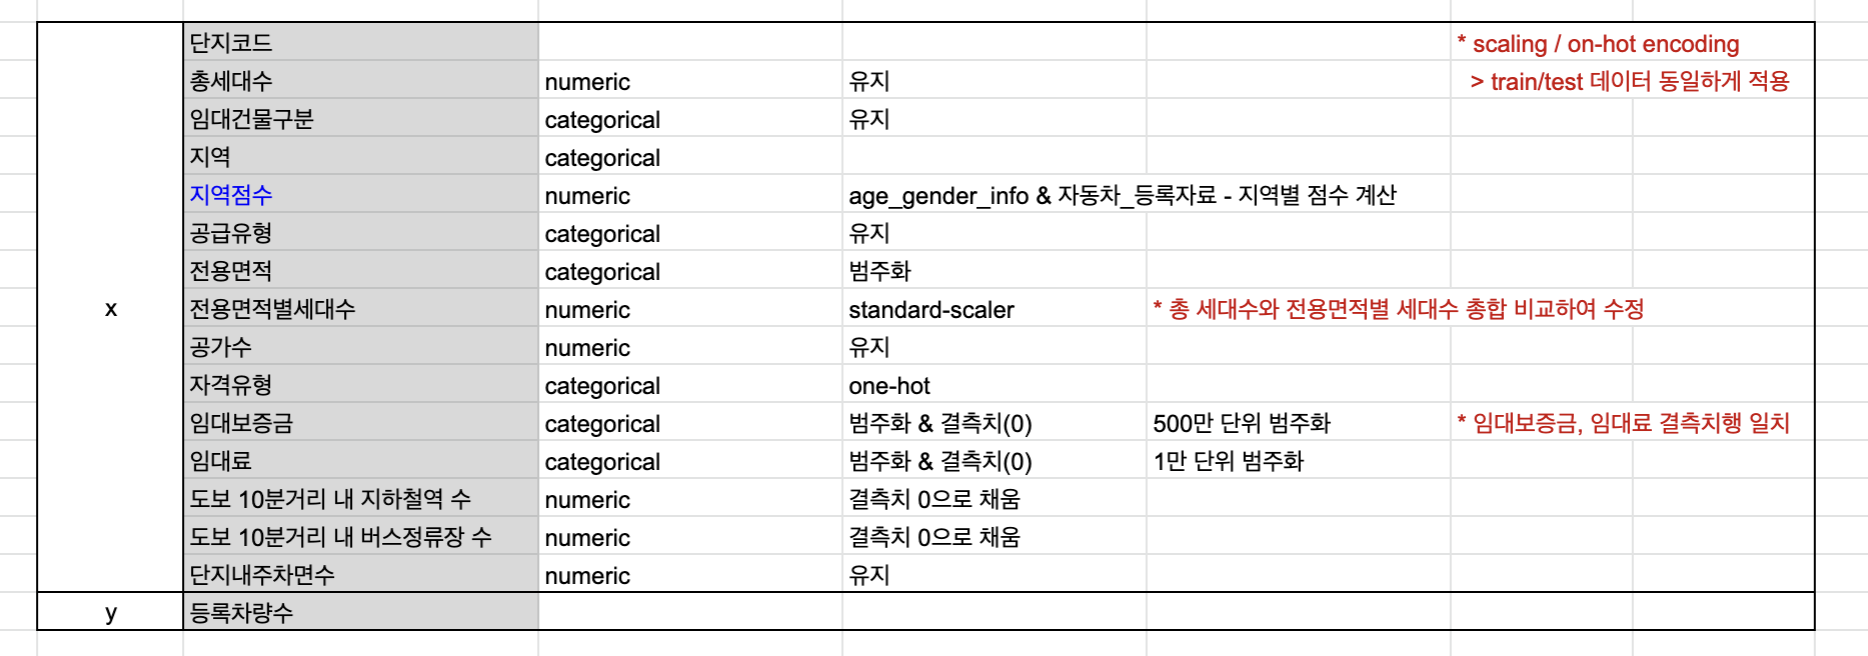

In [36]:
x_train.head(1)

,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,지역점수
0,900,아파트,경상북도,국민임대,39.72,134.0,38.0,A,15667000,103680,0.0,3.0,1425.0,71541.59246


In [37]:
# Feature dtype별 정리
numeric_features = ['총세대수','전용면적별세대수','공가수'
               ,'도보 10분거리 내 지하철역 수(환승노선 수 반영)', '도보 10분거리 내 버스정류장 수','단지내주차면수','지역점수'
               ,'전용면적', '임대보증금', '임대료']

numeric_transformer = StandardScaler()

categorical_features = ['임대건물구분', '공급유형', '자격유형', '지역']
categorical_transformer = OneHotEncoder(categories='auto',sparse = False)

In [38]:
# 전처리용 transformer 만들고, pipeline 생성
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])
preprocessor_pipe = Pipeline(steps=[('preprocessor', preprocessor)])
preprocessor_pipe.fit(train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['총세대수', '전용면적별세대수', '공가수',
                                                   '도보 10분거리 내 지하철역 수(환승노선 수 '
                                                   '반영)',
                                                   '도보 10분거리 내 버스정류장 수',
                                                   '단지내주차면수', '지역점수', '전용면적',
                                                   '임대보증금', '임대료']),
                                                 ('cat',
                                                  OneHotEncoder(sparse=False),
                                                  ['임대건물구분', '공급유형', '자격유형',
                                                   '지역'])]))])

In [39]:
preprocessor.named_transformers_['cat'].get_feature_names(categorical_features)

array(['임대건물구분_상가', '임대건물구분_아파트', '공급유형_공공분양', '공급유형_공공임대(10년)',
       '공급유형_공공임대(50년)', '공급유형_공공임대(5년)', '공급유형_공공임대(분납)', '공급유형_국민임대',
       '공급유형_영구임대', '공급유형_임대상가', '공급유형_장기전세', '공급유형_행복주택', '자격유형_A',
       '자격유형_B', '자격유형_C', '자격유형_D', '자격유형_E', '자격유형_F', '자격유형_G',
       '자격유형_H', '자격유형_I', '자격유형_J', '자격유형_K', '자격유형_L', '자격유형_M',
       '자격유형_N', '자격유형_O', '지역_강원도', '지역_경기도', '지역_경상남도', '지역_경상북도',
       '지역_광주광역시', '지역_대구광역시', '지역_대전광역시', '지역_부산광역시', '지역_서울특별시',
       '지역_세종특별자치시', '지역_울산광역시', '지역_전라남도', '지역_전라북도', '지역_제주특별자치도',
       '지역_충청남도', '지역_충청북도'], dtype=object)

In [40]:
# Coumn명 살리기
feature_names_arr = np.array(numeric_features)
feature_names_arr = np.append(feature_names_arr, preprocessor.named_transformers_['cat'].get_feature_names(categorical_features) )


In [41]:
# train, test data pipeline 통과
x_train = pd.DataFrame(preprocessor_pipe.transform(train), columns = feature_names_arr)
x_test = pd.DataFrame(preprocessor_pipe.transform(test), columns = feature_names_arr)

In [42]:
x_train.head()

,총세대수,전용면적별세대수,공가수,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,지역점수,전용면적,임대보증금,임대료,...,지역_대전광역시,지역_부산광역시,지역_서울특별시,지역_세종특별자치시,지역_울산광역시,지역_전라남도,지역_전라북도,지역_제주특별자치도,지역_충청남도,지역_충청북도
0,0.022231,0.229402,2.317848,-0.397873,-0.264505,2.122213,-0.312078,-0.153544,-0.259396,-0.371703,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.022231,-0.662687,2.317848,-0.397873,-0.264505,2.122213,-0.312078,-0.153544,-0.259396,-0.371703,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.022231,2.111036,2.317848,-0.397873,-0.264505,2.122213,-0.312078,0.228747,0.309824,0.207114,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.022231,-0.662687,2.317848,-0.397873,-0.264505,2.122213,-0.312078,0.228747,0.309824,0.207114,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.022231,-0.467777,2.317848,-0.397873,-0.264505,2.122213,-0.312078,0.228747,0.309824,0.207114,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<br>

## Train / Test Split

In [43]:
from sklearn.model_selection import train_test_split

In [44]:
xx_train, xx_test, yy_train, yy_test = train_test_split(x_train, y_train, test_size=0.3, random_state=0)

## ML

In [45]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

### LinearRegression

In [46]:
from sklearn.linear_model import LinearRegression

In [47]:
line_reg = LinearRegression()
line_reg.fit(xx_train, yy_train)

print("MAE:", round(mean_absolute_error(yy_test,line_reg.predict(xx_test) ), 4))
print("MSE:", round(mean_squared_error(yy_test,line_reg.predict(xx_test) ), 4))

MAE: 126.2386
MSE: 32145.6539


### XGB boost

In [48]:
from xgboost import XGBRegressor

In [150]:
XGB_reg = XGBRegressor(random_state=0)
XGB_reg.fit(xx_train, yy_train)

print("MAE:", round(mean_absolute_error(yy_test,XGB_reg.predict(xx_test) ), 4))
print("MSE:", round(mean_squared_error(yy_test,XGB_reg.predict(xx_test) ), 4))
# XGB_reg.

MAE: 75.6074
MSE: 11204.0734


### Cat boost
내용 : https://dailyheumsi.tistory.com/136

In [137]:
# !pip install catboost
from catboost import CatBoostRegressor

In [139]:
CAT_reg = CatBoostRegressor(
#          cat_features=cat_features,
         loss_function='MAE',
#          ,n_estimators=500, 
#          learning_rate=0.01, 
         random_state=0
    )
CAT_reg.fit(xx_train,yy_train)
print("MAE:", round(mean_absolute_error(yy_test,CAT_reg.predict(xx_test) ), 4))
print("MSE:", round(mean_squared_error(yy_test,CAT_reg.predict(xx_test) ), 4))

0:	learn: 312.1990368	total: 151ms	remaining: 2m 30s
1:	learn: 305.8370125	total: 153ms	remaining: 1m 16s
2:	learn: 299.2802830	total: 154ms	remaining: 51.3s
3:	learn: 293.1180466	total: 156ms	remaining: 38.8s
4:	learn: 287.0428376	total: 158ms	remaining: 31.4s
5:	learn: 281.7740066	total: 159ms	remaining: 26.4s
6:	learn: 276.5136690	total: 161ms	remaining: 22.8s
7:	learn: 271.1868936	total: 163ms	remaining: 20.2s
8:	learn: 265.9290730	total: 164ms	remaining: 18.1s
9:	learn: 260.7038916	total: 166ms	remaining: 16.4s
10:	learn: 255.9345408	total: 168ms	remaining: 15.1s
11:	learn: 251.3138063	total: 169ms	remaining: 13.9s
12:	learn: 245.9902525	total: 171ms	remaining: 13s
13:	learn: 241.2302741	total: 173ms	remaining: 12.2s
14:	learn: 237.0186053	total: 175ms	remaining: 11.5s
15:	learn: 232.7893517	total: 177ms	remaining: 10.9s
16:	learn: 229.3180424	total: 178ms	remaining: 10.3s
17:	learn: 225.2676930	total: 180ms	remaining: 9.82s
18:	learn: 221.1010520	total: 182ms	remaining: 9.38s
19:

185:	learn: 85.8804542	total: 486ms	remaining: 2.13s
186:	learn: 85.5528208	total: 488ms	remaining: 2.12s
187:	learn: 85.3598464	total: 490ms	remaining: 2.12s
188:	learn: 85.2737238	total: 492ms	remaining: 2.11s
189:	learn: 85.0769240	total: 494ms	remaining: 2.1s
190:	learn: 84.9460627	total: 496ms	remaining: 2.1s
191:	learn: 84.6018536	total: 497ms	remaining: 2.09s
192:	learn: 84.4568548	total: 499ms	remaining: 2.09s
193:	learn: 84.2936344	total: 502ms	remaining: 2.08s
194:	learn: 84.2243475	total: 504ms	remaining: 2.08s
195:	learn: 84.1349782	total: 505ms	remaining: 2.07s
196:	learn: 83.8429294	total: 507ms	remaining: 2.07s
197:	learn: 83.7336131	total: 509ms	remaining: 2.06s
198:	learn: 83.6481906	total: 511ms	remaining: 2.06s
199:	learn: 83.4159808	total: 513ms	remaining: 2.05s
200:	learn: 83.1631209	total: 515ms	remaining: 2.05s
201:	learn: 82.8124347	total: 517ms	remaining: 2.04s
202:	learn: 82.6644051	total: 519ms	remaining: 2.04s
203:	learn: 82.5446958	total: 521ms	remaining: 2

355:	learn: 65.5858204	total: 822ms	remaining: 1.49s
356:	learn: 65.5554048	total: 824ms	remaining: 1.48s
357:	learn: 65.5215367	total: 826ms	remaining: 1.48s
358:	learn: 65.4991656	total: 828ms	remaining: 1.48s
359:	learn: 65.4385840	total: 829ms	remaining: 1.47s
360:	learn: 65.4126191	total: 831ms	remaining: 1.47s
361:	learn: 65.3269370	total: 833ms	remaining: 1.47s
362:	learn: 65.2272789	total: 835ms	remaining: 1.47s
363:	learn: 65.1905240	total: 837ms	remaining: 1.46s
364:	learn: 65.1406925	total: 838ms	remaining: 1.46s
365:	learn: 65.0678997	total: 840ms	remaining: 1.46s
366:	learn: 65.0356878	total: 842ms	remaining: 1.45s
367:	learn: 64.9818101	total: 844ms	remaining: 1.45s
368:	learn: 64.9171077	total: 846ms	remaining: 1.45s
369:	learn: 64.8531722	total: 847ms	remaining: 1.44s
370:	learn: 64.8374751	total: 849ms	remaining: 1.44s
371:	learn: 64.7482771	total: 851ms	remaining: 1.44s
372:	learn: 64.6789781	total: 853ms	remaining: 1.43s
373:	learn: 64.6489686	total: 855ms	remaining:

530:	learn: 56.8458735	total: 1.16s	remaining: 1.02s
531:	learn: 56.7961689	total: 1.16s	remaining: 1.02s
532:	learn: 56.7552466	total: 1.16s	remaining: 1.02s
533:	learn: 56.6944752	total: 1.16s	remaining: 1.01s
534:	learn: 56.6748712	total: 1.16s	remaining: 1.01s
535:	learn: 56.6400049	total: 1.17s	remaining: 1.01s
536:	learn: 56.6074670	total: 1.17s	remaining: 1.01s
537:	learn: 56.5909786	total: 1.17s	remaining: 1s
538:	learn: 56.5548600	total: 1.17s	remaining: 1s
539:	learn: 56.5114227	total: 1.17s	remaining: 1000ms
540:	learn: 56.4894868	total: 1.18s	remaining: 998ms
541:	learn: 56.4525421	total: 1.18s	remaining: 995ms
542:	learn: 56.4160007	total: 1.18s	remaining: 993ms
543:	learn: 56.3700959	total: 1.18s	remaining: 991ms
544:	learn: 56.3438970	total: 1.18s	remaining: 989ms
545:	learn: 56.3083028	total: 1.19s	remaining: 986ms
546:	learn: 56.2999512	total: 1.19s	remaining: 984ms
547:	learn: 56.2791701	total: 1.19s	remaining: 982ms
548:	learn: 56.2200926	total: 1.19s	remaining: 979m

704:	learn: 51.4981338	total: 1.49s	remaining: 623ms
705:	learn: 51.4725892	total: 1.49s	remaining: 621ms
706:	learn: 51.4529394	total: 1.49s	remaining: 619ms
707:	learn: 51.3275762	total: 1.5s	remaining: 617ms
708:	learn: 51.3261310	total: 1.5s	remaining: 614ms
709:	learn: 51.3187183	total: 1.5s	remaining: 612ms
710:	learn: 51.3024624	total: 1.5s	remaining: 610ms
711:	learn: 51.2942785	total: 1.5s	remaining: 608ms
712:	learn: 51.2670803	total: 1.5s	remaining: 606ms
713:	learn: 51.2636401	total: 1.51s	remaining: 603ms
714:	learn: 51.1257216	total: 1.51s	remaining: 601ms
715:	learn: 51.1230004	total: 1.51s	remaining: 599ms
716:	learn: 51.0895163	total: 1.51s	remaining: 597ms
717:	learn: 51.0587261	total: 1.51s	remaining: 594ms
718:	learn: 51.0258616	total: 1.51s	remaining: 592ms
719:	learn: 50.9386223	total: 1.52s	remaining: 590ms
720:	learn: 50.9217160	total: 1.52s	remaining: 588ms
721:	learn: 50.9191621	total: 1.52s	remaining: 585ms
722:	learn: 50.9124919	total: 1.52s	remaining: 583ms

889:	learn: 46.2838270	total: 1.83s	remaining: 226ms
890:	learn: 46.2543340	total: 1.83s	remaining: 224ms
891:	learn: 46.2337978	total: 1.83s	remaining: 222ms
892:	learn: 46.1885697	total: 1.83s	remaining: 219ms
893:	learn: 46.1599043	total: 1.83s	remaining: 217ms
894:	learn: 46.1534015	total: 1.83s	remaining: 215ms
895:	learn: 46.1427992	total: 1.84s	remaining: 213ms
896:	learn: 46.1320220	total: 1.84s	remaining: 211ms
897:	learn: 46.1046050	total: 1.84s	remaining: 209ms
898:	learn: 46.1024180	total: 1.84s	remaining: 207ms
899:	learn: 46.0958937	total: 1.84s	remaining: 205ms
900:	learn: 46.0887182	total: 1.85s	remaining: 203ms
901:	learn: 46.0804304	total: 1.85s	remaining: 201ms
902:	learn: 46.0649107	total: 1.85s	remaining: 199ms
903:	learn: 46.0472863	total: 1.85s	remaining: 197ms
904:	learn: 46.0064191	total: 1.85s	remaining: 195ms
905:	learn: 45.9737035	total: 1.85s	remaining: 193ms
906:	learn: 45.9354614	total: 1.86s	remaining: 190ms
907:	learn: 45.9177356	total: 1.86s	remaining:

### NG boost
https://github.com/stanfordmlgroup/ngboost

In [ ]:
# conda install -c conda-forge ngboost

In [154]:
from ngboost import NGBRegressor

In [156]:
NGB_reg = NGBRegressor()
NGB_reg.fit(x_train, y_train)

print("MAE:", round(mean_absolute_error(yy_test,NGB_reg.predict(xx_test) ), 4))
print("MSE:", round(mean_squared_error(yy_test,NGB_reg.predict(xx_test) ), 4))

C:\Users\RYU\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[iter 0] loss=7.4773 val_loss=0.0000 scale=1.0000 norm=323.0294
[iter 100] loss=6.6168 val_loss=0.0000 scale=2.0000 norm=249.8553
[iter 200] loss=6.1388 val_loss=0.0000 scale=2.0000 norm=180.3962
[iter 300] loss=5.8882 val_loss=0.0000 scale=2.0000 norm=160.0288
[iter 400] loss=5.7736 val_loss=0.0000 scale=0.5000 norm=37.9989
MAE: 74.5066
MSE: 10531.108


### SVM

In [49]:
from sklearn.svm import SVR

In [50]:
SVM_reg = SVR()
SVM_reg.fit(xx_train, yy_train)
print("MAE:", round(mean_absolute_error(yy_test,SVM_reg.predict(xx_test) ), 4))
print("MSE:", round(mean_squared_error(yy_test,SVM_reg.predict(xx_test) ), 4))

MAE: 246.5748
MSE: 141288.9034


<br>

## Dacon 답안 제출

In [57]:
answer = pd.read_csv('data/sample_submission.csv')
answer.head()

,code,num
0,C1072,0
1,C1128,0
2,C1456,0
3,C1840,0
4,C1332,0


<br>

# Deep Learning

In [65]:
# loss curve func
def plot_loss_curve(total_epoch=10, start=1):
    plt.figure(figsize=(15, 5))
    plt.plot(range(start, total_epoch +1), history.history['loss'][start-1:total_epoch], label='Train')
    plt.plot(range(start, total_epoch +1), history.history['val_loss'][start-1:total_epoch], label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('mae')
    plt.legend()
    plt.show()

In [58]:
import tensorflow as tf
from tensorflow.keras import datasets, utils
from tensorflow.keras import models, layers, activations, initializers, losses, optimizers, metrics

In [59]:
import os
# tf.logging.set_verbosity(tf.logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [60]:
model = models.Sequential() 

model.add(layers.Dense(input_dim=53, units=64, activation=None, kernel_initializer=initializers.he_uniform())) # he-uniform initialization
model.add(layers.Activation('elu')) # elu, relu / layers.ELU, layers.LeakyReLU

model.add(layers.Dense(units=64, activation=None, kernel_initializer=initializers.he_uniform())) 
model.add(layers.Activation('elu'))

model.add(layers.Dense(units=32, activation=None, kernel_initializer=initializers.he_uniform())) 
model.add(layers.Activation('elu'))

# dropout
model.add(layers.Dropout(rate=0.4)) 

model.add(layers.Dense(units=1, activation=None))

In [61]:
model.compile(optimizer=optimizers.Adam(),
              loss=losses.mean_absolute_error, # MAE / mean_absolute_error
              metrics=[metrics.mae])

In [62]:
history = model.fit(xx_train, yy_train, batch_size=100, epochs=1000, validation_split=0.3, verbose=0)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


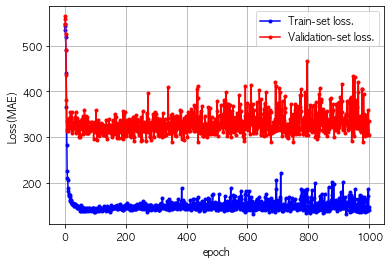

In [63]:
loss = history.history['mean_absolute_error']
val_loss = history.history['val_mean_absolute_error']

x_len = np.arange(len(loss))

plt.plot(x_len, loss, marker='.', c='blue', label="Train-set loss.")
plt.plot(x_len, val_loss, marker='.', c='red', label="Validation-set loss.")

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('Loss(MAE)')
plt.show()

In [64]:
model.predict(x_test)[:10]

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


array([[ 633.7768 ],
       [ 668.726  ],
       [ 663.68256],
       [ 664.43243],
       [ 666.539  ],
       [ 665.69543],
       [ 684.44556],
       [ 668.34796],
       [1135.2031 ],
       [1127.8932 ]], dtype=float32)

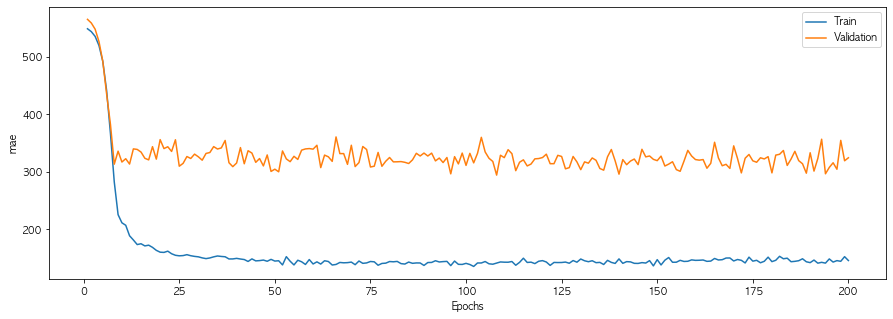

In [66]:
plot_loss_curve(total_epoch=200, start=1)

In [67]:
yy_pred = model.predict(xx_train)
yy_pred[:10]

array([[1774.2955 ],
       [ 177.94296],
       [ 515.5181 ],
       [ 754.7885 ],
       [ 917.8373 ],
       [ 804.2226 ],
       [ 416.30698],
       [ 680.6654 ],
       [  62.40194],
       [ 184.06839]], dtype=float32)

In [68]:
yy_train[:10]

,등록차량수
2494,2550.0
261,116.0
1773,512.0
2584,701.0
1062,826.0
2028,1090.0
1516,540.0
149,671.0
107,62.0
1675,207.0


<br>

## 딥러닝 성능 최적화

### Activation func 변경

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
28/28 [==============================] - 0s 282us/step - loss: 53.0795 - mae: 53.0795
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.a

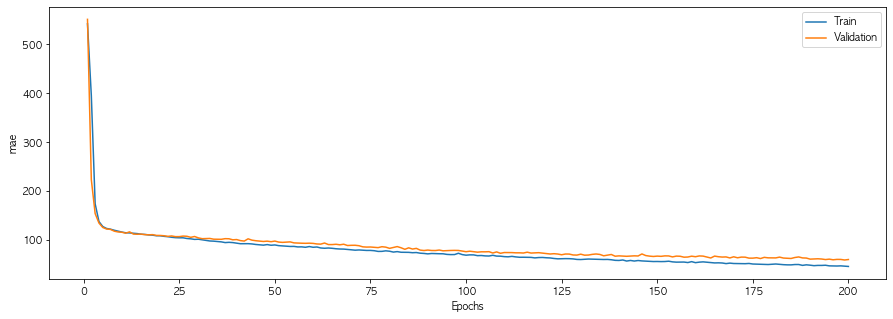

In [69]:
def build_model(num_input=1):
    model = models.Sequential()
    model.add(layers.Dense(input_dim=53, units=64, activation=None, kernel_initializer=initializers.he_uniform()))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dense(1, activation='linear'))
    
    model.compile(optimizer='adam', loss='mae', metrics=['mae'])
    
    return model

model = build_model(num_input=13)

# 미니 배치 학습
model.fit(xx_train, yy_train, epochs=200, batch_size=32, verbose=0)

# 모델 평가
result = model.evaluate(xx_test, yy_test)

# 교차 검증
model = build_model(num_input=13)
history = model.fit(xx_train, yy_train, batch_size=32, epochs=200, validation_split=0.25, verbose=0) 

plot_loss_curve(total_epoch=200, start=1)

In [70]:
print('loss(MAE) - test :', result[0])

loss(MAE) - test : 53.07950973510742


<br>

# 최종 비교